# Produce drift velocity XY map

<i>
This notebook takes a clean kDST, measures the drift
velocity at different points of the XY plane and stores
this map in a hdf5 file.
</i>

### Notebook configuration

In [44]:
run_number          = 5365
input_dst_filename  = f"$IC_DATA/Kr/dst_{run_number}_filtered.root.h5"
correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
plots_output_folder = f"plots/{run_number}/"

Zrange  =  500,  600
XYrange = -200,  200
Znbins  =   50
XYnbins =   50

# Plotting style
default_cmap = "jet"
figure_size  = 16, 12
font_size    = 15

save_plots   = True
with_titles  = False
plots_format = "pdf"

### Imports

In [45]:
import os
import time
import collections

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro.hst_functions  import display_matrix
from invisible_cities.icaro.hst_functions  import shift_to_bin_centers
from invisible_cities.icaro.hst_functions  import measurement_string
from invisible_cities.icaro.hst_functions  import plot_writer

from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(with_titles)

%matplotlib inline

### Initialization

In [46]:
Zbins     = np.linspace(* Zrange,  Znbins + 1)
XYbins    = np.linspace(*XYrange, XYnbins + 1)
Zcenters  = shift_to_bin_centers( Zbins)
XYcenters = shift_to_bin_centers(XYbins)
XYpitch   = np.diff(XYbins)[0]

input_dst_filename = os.path.expandvars( input_dst_filename)

save = plot_writer(plots_output_folder, plots_format) if save_plots else lambda *x: None

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

### Read data

In [47]:
dst           = dstf.load_dst(input_dst_filename, "DST", "Events")
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 1216263 
Total number of events: 1212413


In [48]:
X = dst.X  .values
Y = dst.Y  .values
Z = dst.Z  .values

### Event distribution

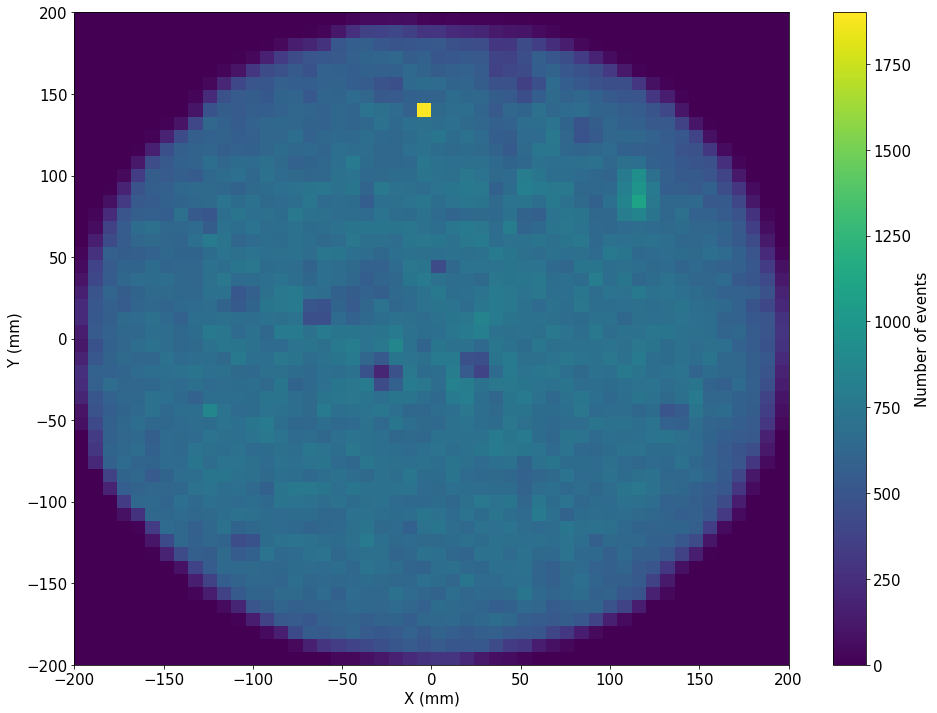

In [49]:
nevt, *_ = plt.hist2d(X, Y, (XYbins, XYbins))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"Event distribution for {XYpitch:.1f} mm pitch")
save(f"EventDistribution_{XYpitch:.1f}mm_XY")

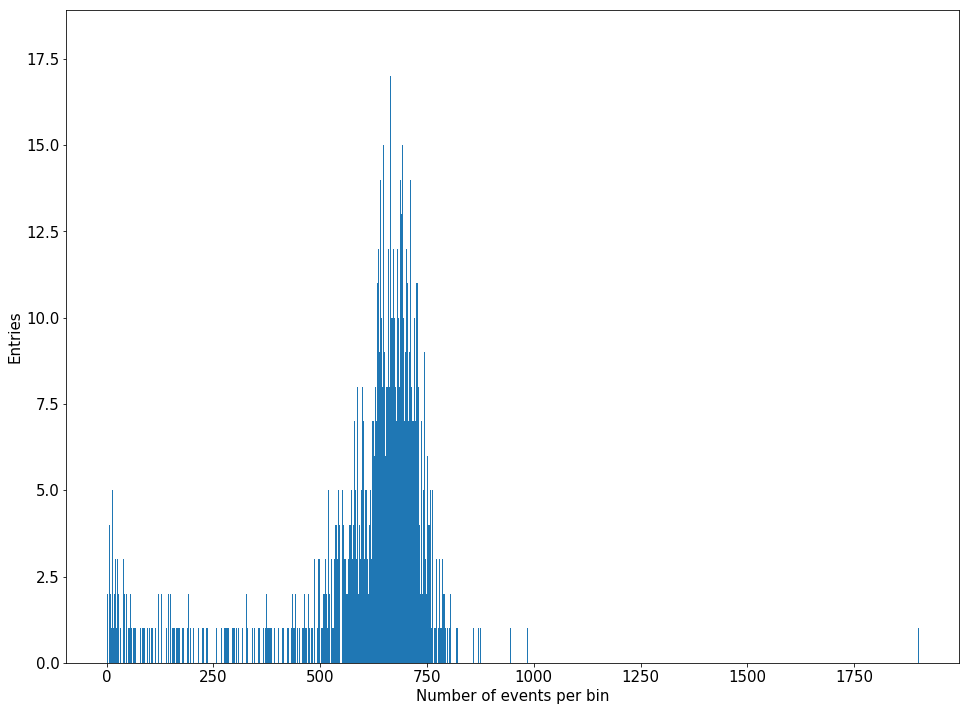

In [50]:
nevt_max = int(np.max(nevt))
plt.hist(nevt.flatten(), np.arange(1, nevt_max+2))
labels("Number of events per bin", "Entries", "# events per bin")
save(f"EventDistribution_{XYpitch:.1f}mm")

### Compute drift velocity map

In [51]:
from invisible_cities.evm .ic_containers  import Measurement
from invisible_cities.core.stat_functions import poisson_sigma

def fit_slices_2d_sigmoid(xdata, ydata, zdata,
                          xbins, ybins, zbins,
                          min_entries = 1e2):
    """
    Slice the data in x and y, histogram the z coordinate
    fit it to a sigmoid and return the relevant values.

    Parameters
    ----------
    xdata, ydata, zdata: array_likes
        Values of each coordinate.
    xbins, ybins, zbins: array_like
        The bins for each coordinate.
    min_entries: int (optional)
        Minimum amount of entries to perform the fit.

    Returns
    -------
    const: Measurement(np.ndarray, np.ndarray)
        Values of const with errors.
    slope: Measurement(np.ndarray, np.ndarray)
        Values of slope with errors.
    chi2: np.ndarray
        Chi2 from each fit.
    valid: boolean np.ndarray
        Where the fit has been succesfull.
    """
    sigmoid  = lambda x, A, B, C, D: A / (1 + np.exp((x - B) / C)) + D

    nbins_x = np.size (xbins) - 1
    nbins_y = np.size (ybins) - 1
    nbins   = nbins_x, nbins_y
    const   = np.zeros(nbins)
    drop    = np.zeros(nbins)
    scale   = np.zeros(nbins)
    offset  = np.zeros(nbins)
    constu  = np.zeros(nbins)
    dropu   = np.zeros(nbins)
    scaleu  = np.zeros(nbins)
    offsetu = np.zeros(nbins)
    chi2    = np.zeros(nbins)
    valid   = np.zeros(nbins, dtype=bool)

    for i in range(nbins_x):
        sel_x = in_range(xdata, *xbins[i:i + 2])
        for j in range(nbins_y):
            sel_y = in_range(ydata, *ybins[j:j + 2])
            sel   = sel_x & sel_y
            if np.count_nonzero(sel) < min_entries: continue

            try:
                y, x = np.histogram(zdata[sel])
                x    = shift_to_bin_centers(x)
                seed = np.max(y), np.mean(Zrange), 10, np.min(y)
                f    = fitf.fit(sigmoid, x, y, seed, sigma=poisson_sigma(y), maxfev=10000)
                const [i, j], constu [i, j] = f.values[0], f.errors[0]
                drop  [i, j], dropu  [i, j] = f.values[1], f.errors[1]
                scale [i, j], scaleu [i, j] = f.values[2], f.errors[2]
                offset[i, j], offsetu[i, j] = f.values[3], f.errors[3]
                chi2  [i, j] = f.chi2
                valid [i, j] = True
            except:
                pass
    return (Measurement(const , constu ),
            Measurement(drop  , dropu  ),
            Measurement(scale , scaleu ),
            Measurement(offset, offsetu),
            chi2, valid)

In [53]:
const, drop,   \
scale, offset, \
chi2, ok       = fit_slices_2d_sigmoid(X, Y, Z, XYbins, XYbins, Zbins, min_entries=50)

dv        = 532 / drop.value
u_dv      =  dv / drop.value * drop.uncertainty

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:31: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(cov))
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


In [54]:
DV_mean = np.nanmean(dv[ok])
DV_std  = np.nanstd (dv[ok])

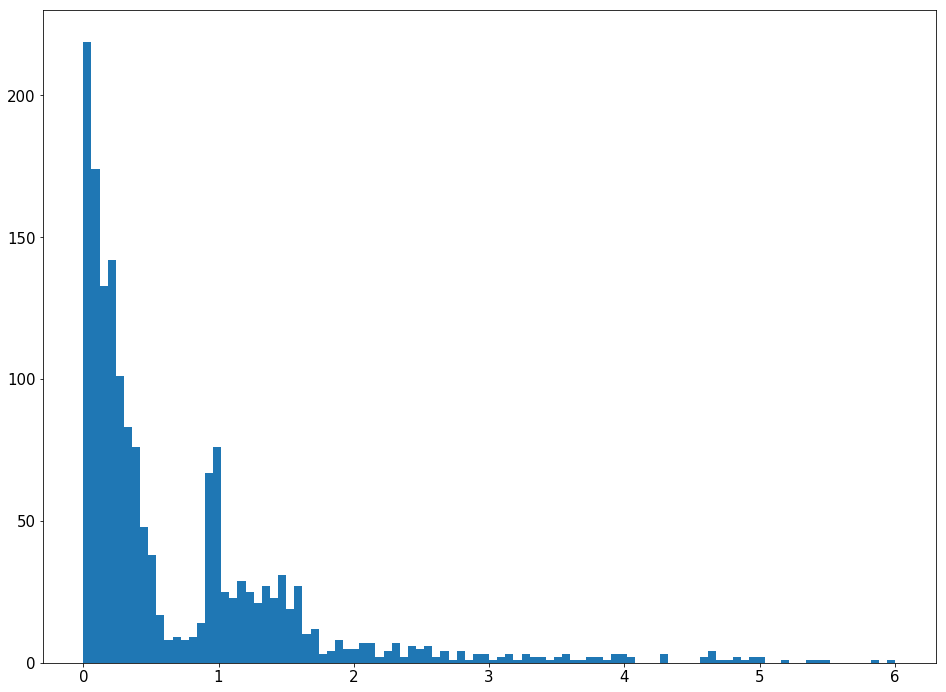

In [55]:
plt.hist(dv.flatten(), 100, (0, 6));

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


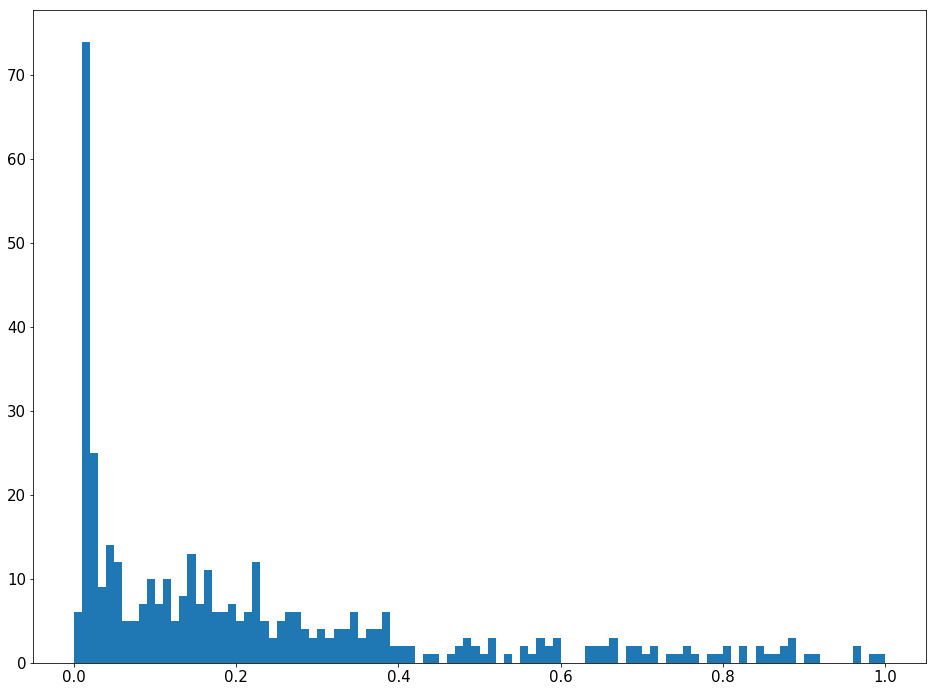

In [57]:
plt.hist(u_dv.flatten(), 100, (0, 1));

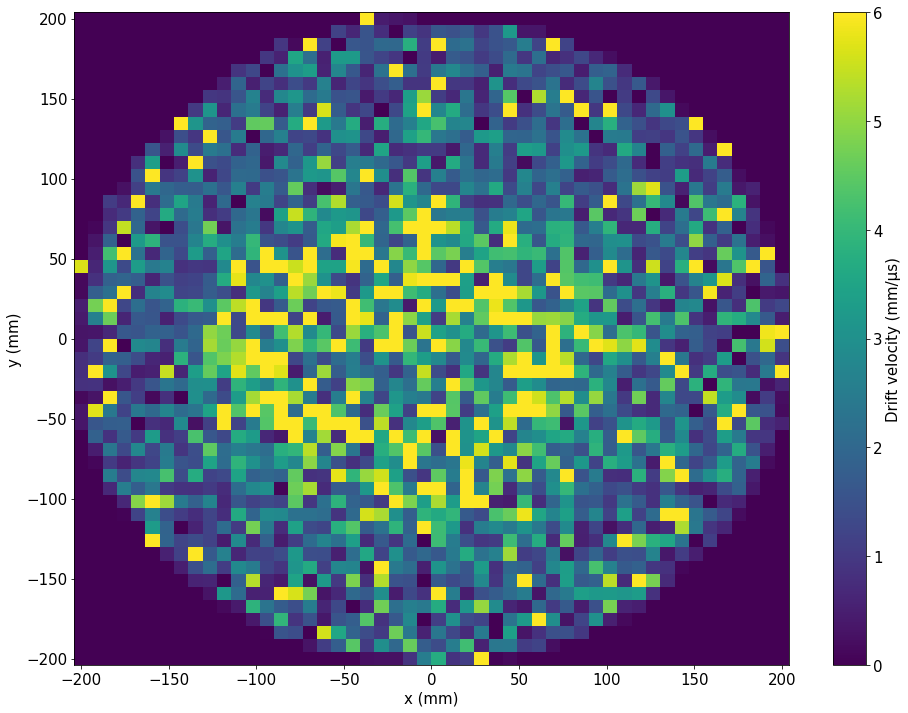

In [58]:
*_, cb = display_matrix(XYcenters, XYcenters, chi2, vmin = 0, vmax = 6)
cb.set_label("Drift velocity (mm/µs)")
labels("x (mm)", "y (mm)")

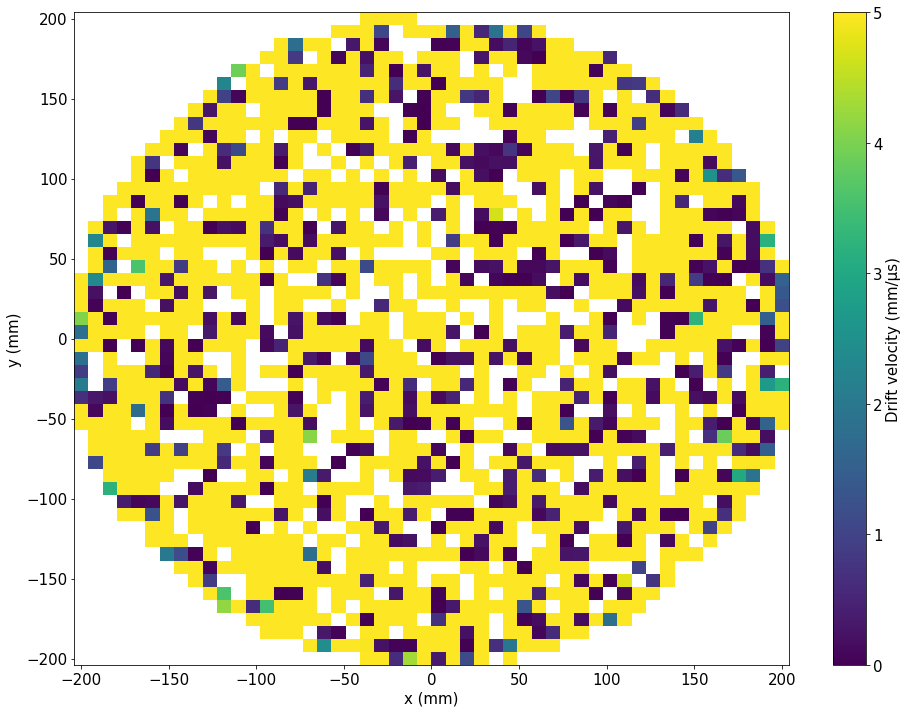

In [59]:
*_, cb = display_matrix(XYcenters, XYcenters, u_dv, vmin=0, vmax=5)
cb.set_label("Drift velocity (mm/µs)")
labels("x (mm)", "y (mm)")

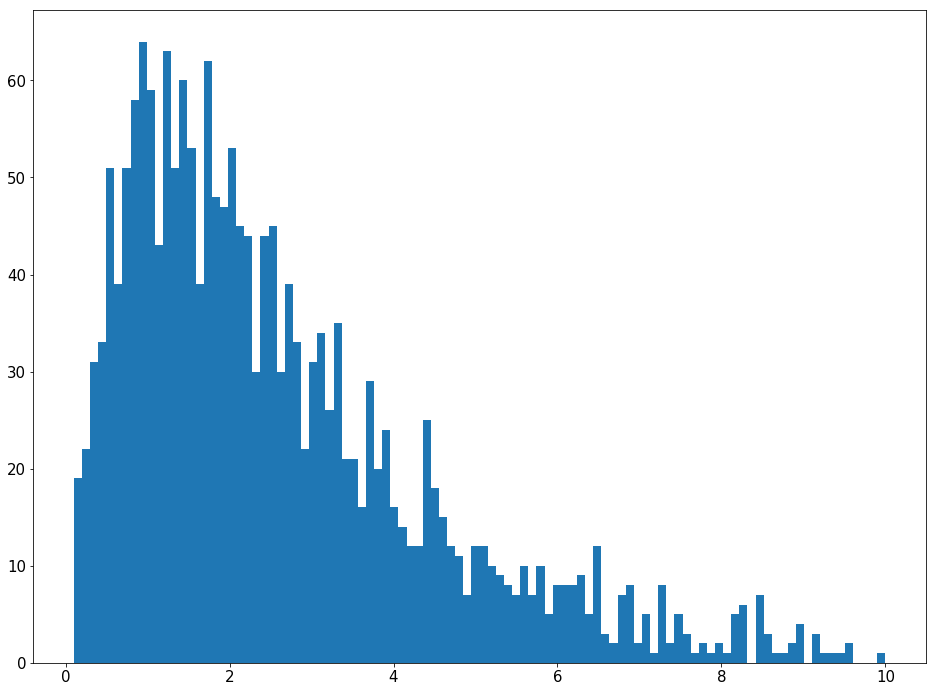

In [63]:
plt.hist(chi2.flatten(), 100, (0.1, 10));

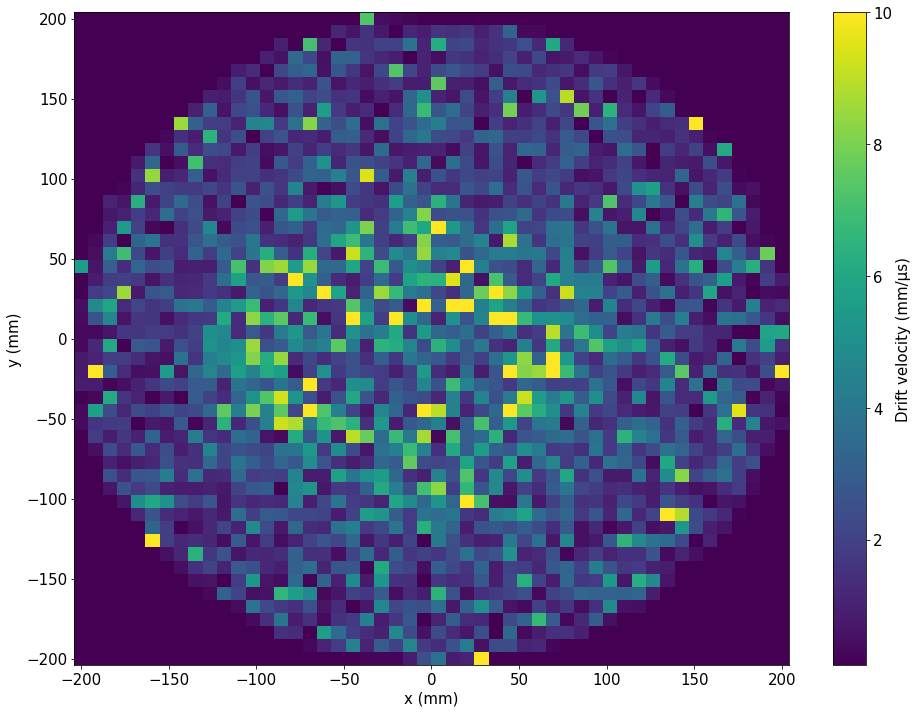

In [64]:
*_, cb = display_matrix(XYcenters, XYcenters, chi2, vmin=0.1, vmax=10)
cb.set_label("Drift velocity (mm/µs)")
labels("x (mm)", "y (mm)")

### Produce HDF5 output